In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import KNNImputer
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV, HalvingGridSearchCV
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor, VotingRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.svm import SVR, LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectFromModel
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/solar-power-generation-data/Plant_2_Generation_Data.csv
/kaggle/input/solar-power-generation-data/Plant_2_Weather_Sensor_Data.csv
/kaggle/input/solar-power-generation-data/Plant_1_Weather_Sensor_Data.csv
/kaggle/input/solar-power-generation-data/Plant_1_Generation_Data.csv


## Project Scope
<ul>
<li>Using solar generation and associated temperature data to explore time series forecasting.</li>
<li>Compare the performance of ML models and a deep learning LSTM model to make a 2-Day forecast of power generation</li>
<li>See what impact including the temperature data has on the forecast</li>
<li>Experiment with feature engineering and test the impact differernt features have on the models</li>
<li>Fine tune the models</li>
<li>Report on what model is ultimately more successful and comment on possible project extensions</li>
</ul>

## Loading and exploring data
This data was taken from two solar plants in India of the course of 34 days in 15 minute intervals. The weather data is on the plant level (just measured from one sensor) and the generation data is gathered from individual inverters across the plant. More information can be found here: 
<a href="https://www.kaggle.com/datasets/anikannal/solar-power-generation-data">Data Card</a>. Credit to 
<a href="https://www.kaggle.com/anikannal">Ani Kannal</a> for uploading this dataset to Kaggle.

In [2]:
plt1_gen = pd.read_csv('/kaggle/input/solar-power-generation-data/Plant_1_Generation_Data.csv')
plt2_gen = pd.read_csv('/kaggle/input/solar-power-generation-data/Plant_2_Generation_Data.csv')
plt1_weather = pd.read_csv('/kaggle/input/solar-power-generation-data/Plant_1_Weather_Sensor_Data.csv')
plt2_weather = pd.read_csv('/kaggle/input/solar-power-generation-data/Plant_2_Weather_Sensor_Data.csv')

In [3]:
plt1_gen.head()

,DATE_TIME,PLANT_ID,SOURCE_KEY,DC_POWER,AC_POWER,DAILY_YIELD,TOTAL_YIELD
0,15-05-2020 00:00,4135001,1BY6WEcLGh8j5v7,0.0,0.0,0.0,6259559.0
1,15-05-2020 00:00,4135001,1IF53ai7Xc0U56Y,0.0,0.0,0.0,6183645.0
2,15-05-2020 00:00,4135001,3PZuoBAID5Wc2HD,0.0,0.0,0.0,6987759.0
3,15-05-2020 00:00,4135001,7JYdWkrLSPkdwr4,0.0,0.0,0.0,7602960.0
4,15-05-2020 00:00,4135001,McdE0feGgRqW7Ca,0.0,0.0,0.0,7158964.0


In [4]:
plt1_gen.tail()

,DATE_TIME,PLANT_ID,SOURCE_KEY,DC_POWER,AC_POWER,DAILY_YIELD,TOTAL_YIELD
68773,17-06-2020 23:45,4135001,uHbuxQJl8lW7ozc,0.0,0.0,5967.000,7287002.0
68774,17-06-2020 23:45,4135001,wCURE6d3bPkepu2,0.0,0.0,5147.625,7028601.0
68775,17-06-2020 23:45,4135001,z9Y9gH1T5YWrNuG,0.0,0.0,5819.000,7251204.0
68776,17-06-2020 23:45,4135001,zBIq5rxdHJRwDNY,0.0,0.0,5817.000,6583369.0
68777,17-06-2020 23:45,4135001,zVJPv84UY57bAof,0.0,0.0,5910.000,7363272.0


Notes: PLANT_ID is the same throughout, so it can be safely removed. The generation for these times is 0, because it is nighttime. Since we are targeting plant level generation, I will groupby DATE_TIME and sum the data for each timestamp. I will then make the datetime the index. First, I'll check for nulls and make sure there is data for every timestamp.

In [5]:
plt1_gen = plt1_gen.drop('PLANT_ID', axis=1)
plt1_gen.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68778 entries, 0 to 68777
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   DATE_TIME    68778 non-null  object 
 1   SOURCE_KEY   68778 non-null  object 
 2   DC_POWER     68778 non-null  float64
 3   AC_POWER     68778 non-null  float64
 4   DAILY_YIELD  68778 non-null  float64
 5   TOTAL_YIELD  68778 non-null  float64
dtypes: float64(4), object(2)
memory usage: 3.1+ MB


Notes: The dtypes make sense. I will need to make the DATE_TIME a datetime dtype. No nulls detected here, but there still could be outliers or nulls encoded in a different way.

In [6]:
plt1_gen.describe().T

,count,mean,std,min,25%,50%,75%,max
DC_POWER,68778.0,3.147426e+03,4036.457169,0.0,0.000000e+00,4.290000e+02,6.366964e+03,14471.125
AC_POWER,68778.0,3.078028e+02,394.396439,0.0,0.000000e+00,4.149375e+01,6.236187e+02,1410.950
DAILY_YIELD,68778.0,3.295969e+03,3145.178309,0.0,0.000000e+00,2.658714e+03,6.274000e+03,9163.000
TOTAL_YIELD,68778.0,6.978712e+06,416271.982856,6183645.0,6.512003e+06,7.146685e+06,7.268706e+06,7846821.000


In [7]:
plt1_gen.SOURCE_KEY.nunique()

22

Notes: There are 22 sources so I would expect there to be 34 * 24 * 4 * 22 = 71808 rows altogether. However, there are only 68777, so 3031 or ~4% of the total are missing. Although probably not enough to greatly inpact our model, I will plan on imputing the missing data. First, I will explore whether these are just some inverters missing data or they are missing at the plant level.

In [8]:
plt1_gen.groupby('SOURCE_KEY').count().DATE_TIME.count()

22

Notes: Each inverter would have 34 * 24 * 4 = 3264 data points if every timestamp was present.

In [9]:
plt1_gen.groupby('SOURCE_KEY').count().DATE_TIME.min()

3104

Notes: The inverter with the least number of readings still has ~95% of the excepted number.

In [10]:
#Switching DATE_TIME column to datetime dtype.
plt1_gen['DATE_TIME'] = pd.to_datetime(plt1_gen.DATE_TIME, format='%d-%m-%Y %H:%M')
plt1_gen.DATE_TIME.nunique() #output 3158

3158

Note: There are also some entire timestamps missing on the plant level. I will impute the missing values next. To do this I will merge the dataset with a datetime series representing all the datetimes we want in our dataset.

In [11]:
#Next I will make a full datetime range series to merge with the plt1_gen dataframe. 
datetime_full = pd.date_range('2020-05-15', '2020-06-17 23:45', freq='15min')
datetime_full = pd.Series(datetime_full, name='DATE_TIME') #making a Series to allow merging

inverters = plt1_gen.SOURCE_KEY.unique()

In [12]:
imputer = KNNImputer()
dfs = []
for i in range(len(inverters)):
    df_source = plt1_gen[plt1_gen['SOURCE_KEY'] == inverters[i]].merge(datetime_full, on='DATE_TIME', how='right')
    datetime = df_source.pop('DATE_TIME')
    df_source.index = datetime
    source = df_source.pop('SOURCE_KEY')
    df_source = pd.DataFrame(imputer.fit_transform(df_source), columns=list(imputer.feature_names_in_))
    df_source = df_source.merge(datetime, left_index=True, right_index=True)
    dfs.append(df_source)
plt1_gen = pd.concat(dfs, axis=0)
plt1_gen = plt1_gen.reset_index(drop=True)
plt1_gen = plt1_gen.groupby('DATE_TIME').sum()

In [13]:
plt1_gen.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3264 entries, 2020-05-15 00:00:00 to 2020-06-17 23:45:00
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   DC_POWER     3264 non-null   float64
 1   AC_POWER     3264 non-null   float64
 2   DAILY_YIELD  3264 non-null   float64
 3   TOTAL_YIELD  3264 non-null   float64
dtypes: float64(4)
memory usage: 127.5 KB


Now we have the full number of expected rows. Next I will impute the missing values. Since we'll ultimately be interested in a 2-Day forecast simluated by lag features of 2 days or more, using the KNNImputer should have limited target leakage. It might be worth trying multiple imputing methods to see what has the best results for the final model. Setting a up a pipeline will help to try out different methods and models quickly.

Text(0.5, 1.0, 'Heatmap')

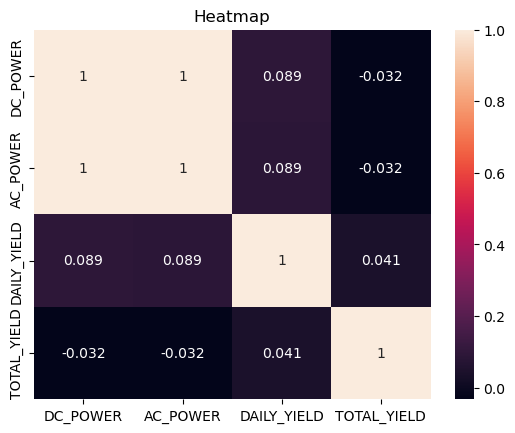

In [14]:
sns.heatmap(plt1_gen.corr(), annot =True)
plt.title('Heatmap')

Not surprisingly DC_POWER and AC_POWER are highly correlated. Since I am ultimately interested in power generation after the inverter inverts to AC, I will make AC_POWER the target, droping the other columns.

In [15]:
df = plt1_gen.drop(['DC_POWER', 'DAILY_YIELD', 'TOTAL_YIELD'], axis=1)

Now we can look at the distribution of the AC power generation data

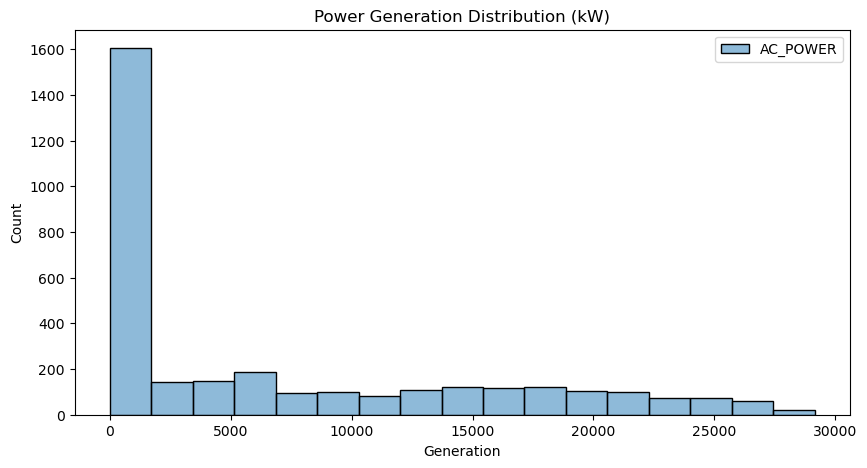

In [16]:
fig, ax = plt.subplots(figsize=(10,5))
sns.histplot(df)
plt.title('Power Generation Distribution (kW)')
plt.xlabel('Generation')
plt.show()

As expected the distribution is dominated by the all the zeros from the nighttime. I will look later at what I can do with these to possibly improve the model. Other the distribution appears to be somewhat bimodal. Let's see if get a better picture of this. To do this I will only look at values greater than 0 and use a KDE plot.

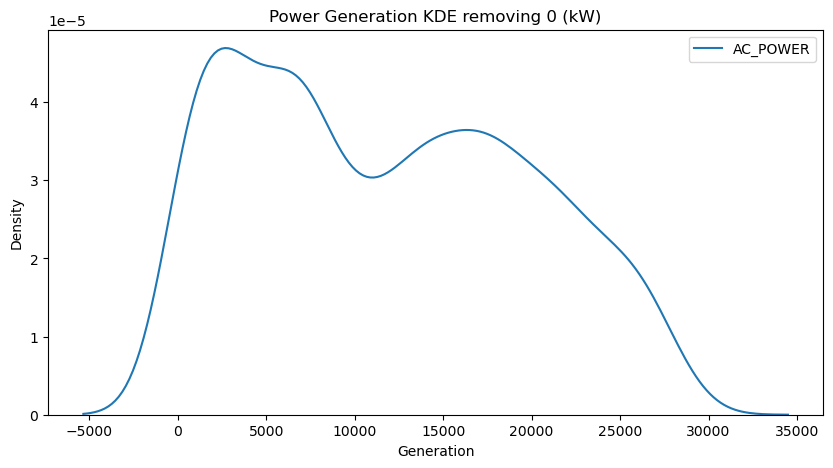

In [17]:
plt.close()
fig, ax = plt.subplots(figsize=(10,5))
sns.kdeplot(df.query('AC_POWER > 0'), )
plt.title('Power Generation KDE removing 0 (kW)')
plt.xlabel('Generation')
plt.show()


Even removing the zeros there are clearly two modes. This does make sense that there would be one mode around 0, because no matter what the weather conditions for the day, the plant is likely to generate at least a little power. Then the mode around 16000 kW is the mean generation at the throughout the day.

Next, let's look at the generation over a one-week period.

Text(0, 0.5, 'kW')

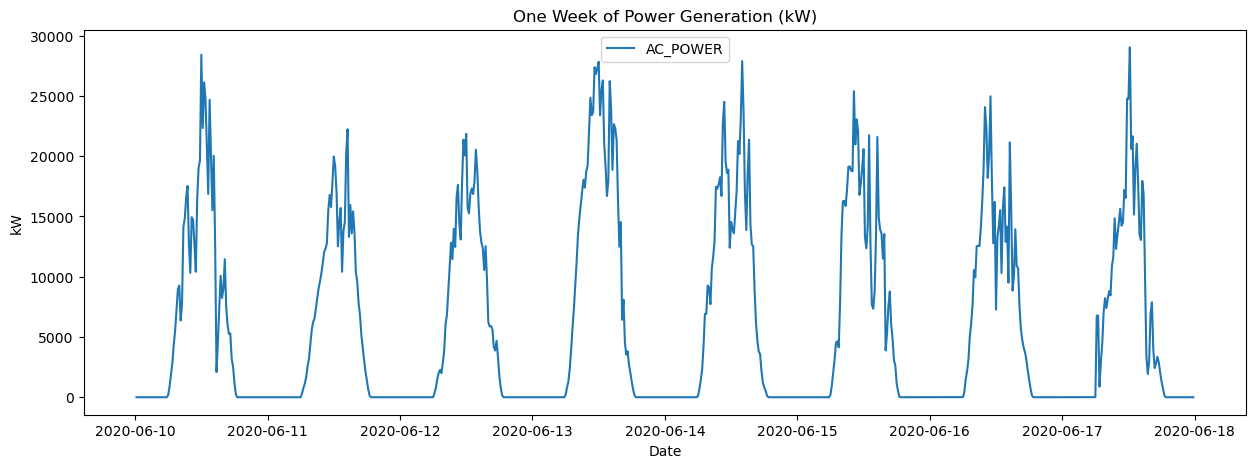

In [18]:
fig, ax = plt.subplots(figsize=(15,5))
sns.lineplot(df[df.index > '2020-06-10'])
plt.title('One Week of Power Generation (kW)')
plt.xlabel('Date')
plt.ylabel('kW')


Notes: This is what we will be modeling. The zeros at nighttime are again clear. We might need to rollup the datetime to make it smoother and easier to model. Finally, some of the quick drops could be do to missing data. I will go ahead and impute the missing values before continuing.

In [19]:
df = df.resample('30min').sum()

Text(0, 0.5, 'kW')

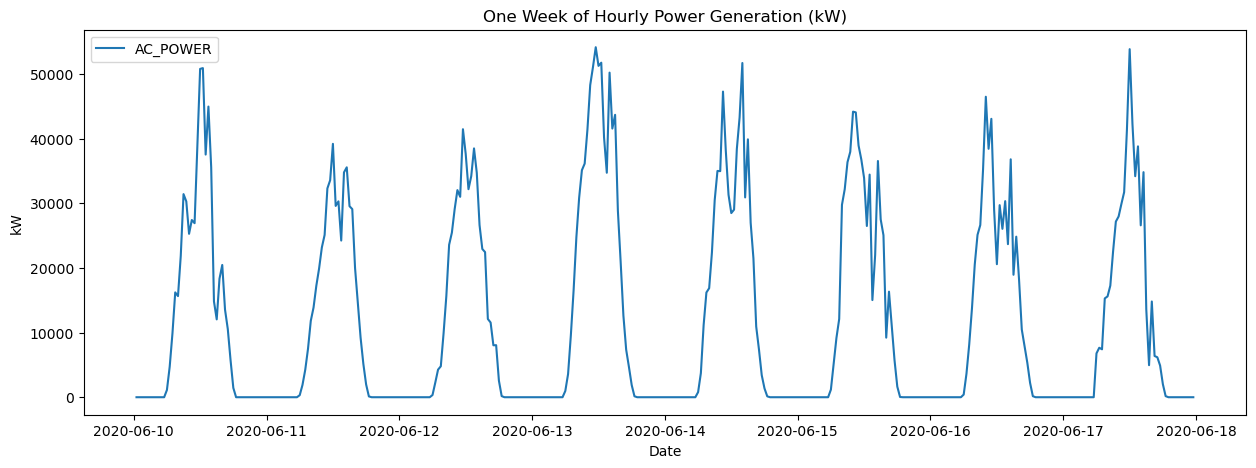

In [20]:
fig, ax = plt.subplots(figsize=(15,5))
sns.lineplot(df[df.index > '2020-06-10'])
plt.title('One Week of Hourly Power Generation (kW)')
plt.xlabel('Date')
plt.ylabel('kW')

Notes: This is much smoother and might be easier for the model to handle. Although it will also have less data to draw from. I will try both the 15min and hourly data to compare how they model.

In [21]:
df_day = df.resample('D').sum()

Text(0, 0.5, 'kW')

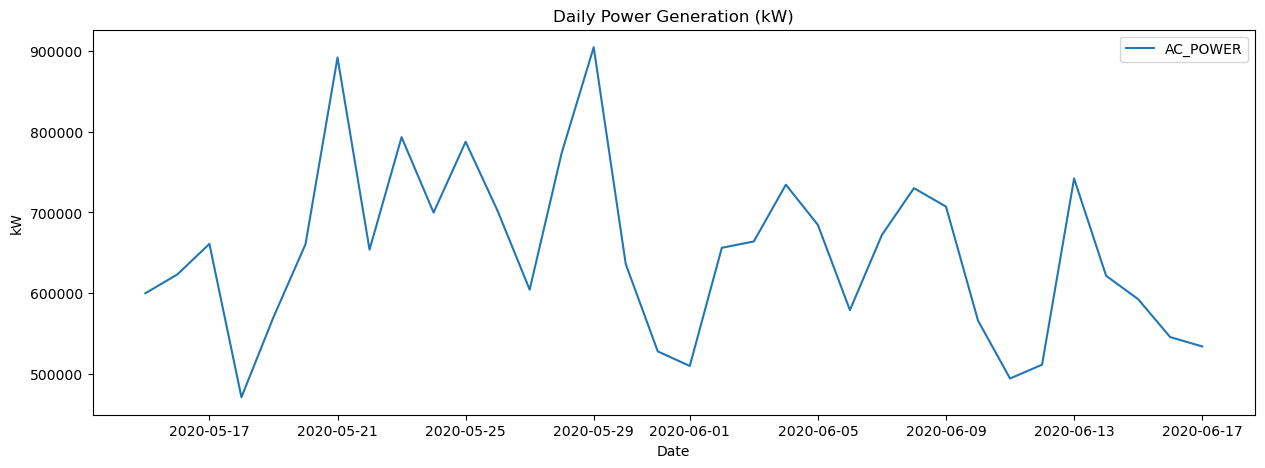

In [22]:
fig, ax = plt.subplots(figsize=(15,5))
sns.lineplot(df_day)
plt.title('Daily Power Generation (kW)')
plt.xlabel('Date')
plt.ylabel('kW')

Note: The daily generation would be difficult to model with more data.

## Feature Engineering
For this time series data I will make a cosine and sine representation of the day and also lag features to emulate the 2-Day forecast. This technique was taken from this times series <a href="https://www.tensorflow.org/tutorials/structured_data/time_series#time">tutorial</a>. 

In [23]:
timestamp_s = df.index.map(pd.Timestamp.timestamp)
day = 24*60*60
df['Day sin'] = np.sin(timestamp_s  * (2 * np.pi / day))
df['Day cos'] = np.cos(timestamp_s * (2 * np.pi / day))

Now making the lag features. We can use feature selection to get the most important ones for our model.

In [24]:
#Creating lag features. Starting with a full range of lag features, we'll use feature selection to find the most important ones:
def lag_creator(df, feature, start, stop, step_size):
    lag_features = [df]
    for i in range(start, start+stop, step_size):
        lag_feature= df[feature].shift(i)
        lag_feature.name = f'lag_{feature}{i}'
        lag_features.append(lag_feature)
    df = pd.concat(lag_features, axis=1)
    return df
df_for_weather_merge = lag_creator(df, 'AC_POWER', 48*2, 4, 48)
df = lag_creator(df, 'AC_POWER', 48*2, 4, 48)
df = df.dropna(axis=0)

        

## Establishing Baseline
Let's have our baseline for our 2-Day forecast that the power generation is going to be the same as it is at the current time. This shouldn't be too terrible of a model, but hopefully our model can easily out perform it. We will use the mean squared error to score our model.

In [25]:
y_baseline = df.AC_POWER.shift(48*2).dropna(axis=0)
df = df[~df.AC_POWER.shift(48*2).isna()]
y = df.pop('AC_POWER')
X = df

In [26]:
tscv = TimeSeriesSplit(test_size=48*2)
cv_index = []
r2_scores = []
for train_index, test_index in tscv.split(X, y):
    cv_index.append((train_index, test_index))
    r2_scores.append(r2_score(y.iloc[test_index], y_baseline.iloc[test_index]))
r2_score = np.mean(r2_scores)
baseline_score = np.round(r2_score, 4)
baseline_score

0.7636

In [27]:
baseline_score = r2_score

## Model Selection
Next we will setup the time series train/test split. I try out the HalvingGridSearchCV to fine-tune the model and also handle the cross validation. The HalvingGridSearchCV is considered an informed searching, spliting the difference between and explict search and a randomized one. In order for the CV to work I will need to do the train/test split specialized for time series and feed the indicies to HalvingGridSearchCV.

First let's get our target and features seperated, then we can get the train/test indicies.

In [28]:
tscv = TimeSeriesSplit(test_size=48*2, n_splits=5)
cv_index = []
for train_index, test_index in tscv.split(X, y):
    cv_index.append((train_index, test_index))

In [29]:
xgb = XGBRegressor(random_state=1)
# First grid tried: {'booster': ['dart', 'gbtree', 'gblinear'], 'n_estimators': [5, 10, 25, 50, 100, 250, 500], 'eta': [0.05, 0.1, 0.3], 'max_depth' : [2,3,5]}
# Best params from first grid {'booster': 'gbtree', 'eta': 0.05, 'max_depth': 2, 'n_estimators': 50} Score: 0.8768231019295916
# Second grid tried: {'booster': ['gbtree'], 'eta': [0.03, 0.04, 0.05, 0.06], 'max_depth': [2], 'n_estimators': [30 + x for x in range(1,21)]}
# Best params from second grid {'booster': 'gbtree', 'eta': 0.05, 'max_depth': 2, 'n_estimators': 44} Score: 0.8794394098766322
# Third grid tried: {'booster': ['gbtree'], 'eta': [0.04 + 0.001*x for x in range(1,21)], 'max_depth': [2], 'n_estimators': [44]}
# Same best params from second grid, so 
param_grid = {'booster': ['gbtree'], 'eta': [0.05], 'max_depth': [2], 'n_estimators': [44]}
gs = GridSearchCV(xgb, param_grid=param_grid, cv=cv_index, verbose=10)
gs.fit(X, y)
gs

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5; 1/1] START booster=gbtree, eta=0.05, max_depth=2, n_estimators=44......
[CV 1/5; 1/1] END booster=gbtree, eta=0.05, max_depth=2, n_estimators=44;, score=0.907 total time=   0.0s
[CV 2/5; 1/1] START booster=gbtree, eta=0.05, max_depth=2, n_estimators=44......
[CV 2/5; 1/1] END booster=gbtree, eta=0.05, max_depth=2, n_estimators=44;, score=0.878 total time=   0.0s
[CV 3/5; 1/1] START booster=gbtree, eta=0.05, max_depth=2, n_estimators=44......
[CV 3/5; 1/1] END booster=gbtree, eta=0.05, max_depth=2, n_estimators=44;, score=0.910 total time=   0.0s
[CV 4/5; 1/1] START booster=gbtree, eta=0.05, max_depth=2, n_estimators=44......
[CV 4/5; 1/1] END booster=gbtree, eta=0.05, max_depth=2, n_estimators=44;, score=0.898 total time=   0.0s
[CV 5/5; 1/1] START booster=gbtree, eta=0.05, max_depth=2, n_estimators=44......
[CV 5/5; 1/1] END booster=gbtree, eta=0.05, max_depth=2, n_estimators=44;, score=0.887 total time=   0.0s


GridSearchCV(cv=[(array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108...
                                    learning_rate=None, max_bin=None,
                                    max_cat_threshold=None,
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None, n_estimators=100,
                                    n_jobs=None, num_parallel_tree=None,
                                    predictor=None, random_state=1, ...),
             param_grid={'booster': ['gbtree'], 'eta': [0.05], 'max_depth': [2],
                         'n_estimators': [44]},
             verbose=10)

In [30]:
gs.best_params_

{'booster': 'gbtree', 'eta': 0.05, 'max_depth': 2, 'n_estimators': 44}

In [31]:
print(gs.best_score_,
gs.cv_results_['std_test_score'][0])

0.896048622646213 0.01204298974047373


## Adding weather data

In [32]:
plt1_weather.head()

,DATE_TIME,PLANT_ID,SOURCE_KEY,AMBIENT_TEMPERATURE,MODULE_TEMPERATURE,IRRADIATION
0,2020-05-15 00:00:00,4135001,HmiyD2TTLFNqkNe,25.184316,22.857507,0.0
1,2020-05-15 00:15:00,4135001,HmiyD2TTLFNqkNe,25.084589,22.761668,0.0
2,2020-05-15 00:30:00,4135001,HmiyD2TTLFNqkNe,24.935753,22.592306,0.0
3,2020-05-15 00:45:00,4135001,HmiyD2TTLFNqkNe,24.846130,22.360852,0.0
4,2020-05-15 01:00:00,4135001,HmiyD2TTLFNqkNe,24.621525,22.165423,0.0


Since only one source and plant are present, PLANT_ID and SOURCE_KEY can safely be removed.

In [33]:
plt1_weather = plt1_weather.drop(['PLANT_ID', 'SOURCE_KEY'], axis=1)
plt1_weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3182 entries, 0 to 3181
Data columns (total 4 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   DATE_TIME            3182 non-null   object 
 1   AMBIENT_TEMPERATURE  3182 non-null   float64
 2   MODULE_TEMPERATURE   3182 non-null   float64
 3   IRRADIATION          3182 non-null   float64
dtypes: float64(3), object(1)
memory usage: 99.6+ KB


Dtypes make sense. Will again need to fill in the missing values by merging with the full datetime range. The datetime format is different this time.

In [34]:
plt1_weather['DATE_TIME'] = pd.to_datetime(plt1_weather.DATE_TIME, format='%Y-%m-%d %H:%M:%S')

datetime_full = pd.date_range('2020-05-15', '2020-06-17 23:45:00', freq='15min')
datetime_full = pd.Series(datetime_full, name='DATE_TIME') #making a Series to allow merging


plt1_weather = plt1_weather.merge(datetime_full, on='DATE_TIME', how='right')


# df_source = plt1_gen[plt1_gen['SOURCE_KEY'] == inverters[i]].merge(datetime_full, on='DATE_TIME', how='right')
# datetime = df_source.pop('DATE_TIME')
# df_source.index = datetime
# source = df_source.pop('SOURCE_KEY')
# df_source = pd.DataFrame(imputer.fit_transform(df_source), columns=list(imputer.feature_names_in_))
# df_source = df_source.merge(datetime, left_index=True, right_index=True)
# dfs.append(df_source)
# plt1_gen = pd.concat(dfs, axis=0)
# plt1_gen = plt1_gen.reset_index(drop=True)
# plt1_gen = plt1_gen.groupby('DATE_TIME').sum()

In [35]:
plt1_weather.index = plt1_weather.pop('DATE_TIME')

## Imputing missing weather data

In [36]:
plt1_weather = pd.DataFrame(imputer.fit_transform(plt1_weather), columns=list(imputer.feature_names_in_), index=datetime_full)
plt1_weather

,AMBIENT_TEMPERATURE,MODULE_TEMPERATURE,IRRADIATION
DATE_TIME,,,
2020-05-15 00:00:00,25.184316,22.857507,0.0
2020-05-15 00:15:00,25.084589,22.761668,0.0
2020-05-15 00:30:00,24.935753,22.592306,0.0
2020-05-15 00:45:00,24.846130,22.360852,0.0
2020-05-15 01:00:00,24.621525,22.165423,0.0
...,...,...,...
2020-06-17 22:45:00,22.150570,21.480377,0.0
2020-06-17 23:00:00,22.129816,21.389024,0.0
2020-06-17 23:15:00,22.008275,20.709211,0.0


<Axes: >

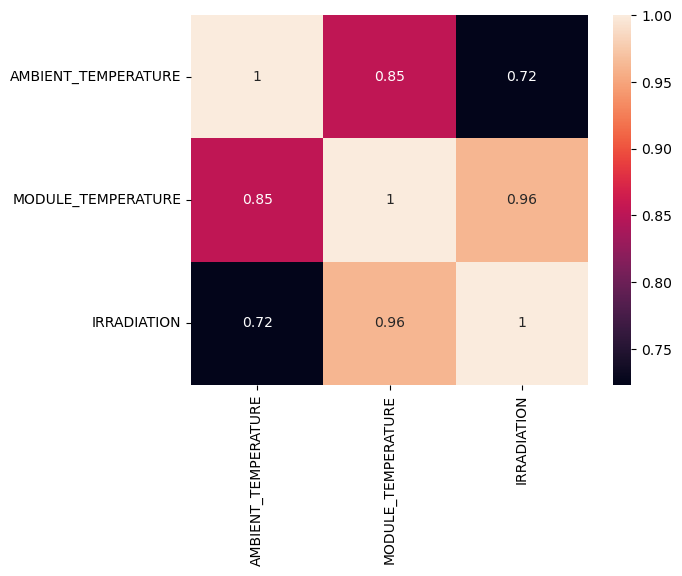

In [37]:
sns.heatmap(plt1_weather.corr(), annot=True)

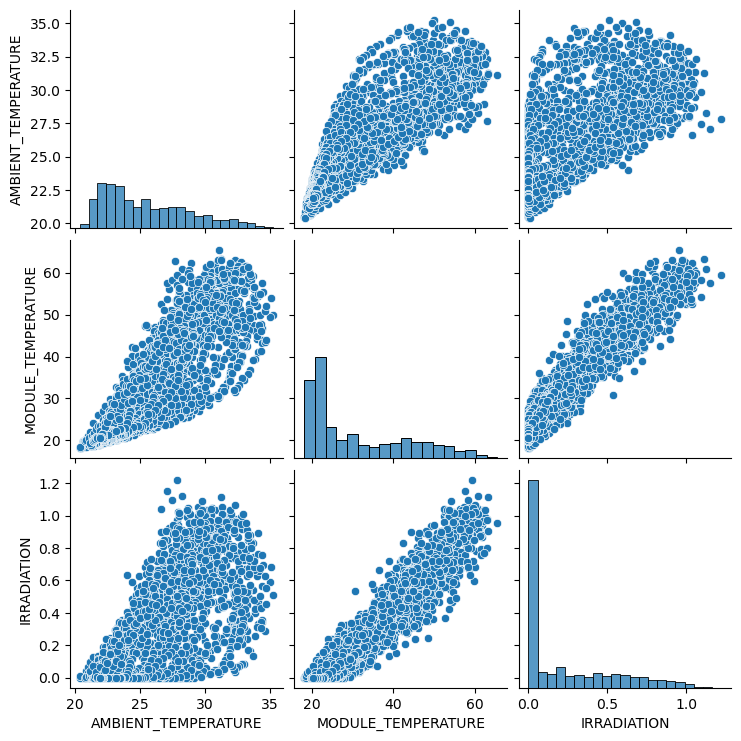

In [38]:
sns.pairplot(plt1_weather)

## Adding weather data with generation data
To do this I will just create the lag features and concatenate them with the generation dataframe.

In [39]:
def lag_creator_features(df, feature, start, stop, step_size):
    lag_features = [df[feature]]
    for i in range(start, start+stop, step_size):
        lag_feature= df[feature].shift(i)
        lag_feature.name = f'lag_{feature}{i}'
        lag_features.append(lag_feature)
    df = pd.concat(lag_features, axis=1)
    df = df.drop(feature, axis=1)
    return df

df_ambient = lag_creator_features(plt1_weather, 'AMBIENT_TEMPERATURE', 48*2, 4, 48)
# df_module = lag_creator_features(plt1_weather, 'MODULE_TEMPERATURE', 48*2, 4, 48)
# df_irradiation = lag_creator_features(plt1_weather, 'IRRADIATION', 48*2, 4, 48)
# df = pd.concat([df_ambient, df_module, df_irradiation, df_for_weather_merge], axis=1)
df = pd.concat([df_ambient, df_for_weather_merge], axis=1)
df = df.dropna(axis=0)
df = df[~df.AC_POWER.shift(48*2).isna()]
y = df[['AC_POWER']]
X = df.drop('AC_POWER', axis=1)


tscv = TimeSeriesSplit(test_size=48*2, n_splits=5)
cv_index = []
for train_index, test_index in tscv.split(X, y):
    cv_index.append((train_index, test_index))

In [40]:
xgb = XGBRegressor(random_state=1)
# First param grid tried {'booster': ['dart', 'gdlinear', 'gbtree'], 'eta': [0.05, 0.1, 0.3], 'n_estimators': [25, 50, 75]}
# Best params {'booster': 'dart', 'eta': 0.1, 'n_estimators': 25}
# Score 0.8672088282978037
# Second param grid tried {'booster': ['dart'], 'eta': [0.08, 0.09, 0.1, 0.11, 0.12], 'n_estimators': [15, 20, 25, 30, 35]}
# Best params {'booster': 'dart', 'eta': 0.11, 'n_estimators': 20}
# Score 0.8683027242763146
param_grid = {'booster': ['dart'], 'eta': [0.11], 'n_estimators': [20]}
gs = GridSearchCV(xgb, param_grid=param_grid, cv=cv_index, verbose=10)
gs.fit(X, y)
gs

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5; 1/1] START booster=dart, eta=0.11, n_estimators=20.....................
[CV 1/5; 1/1] END booster=dart, eta=0.11, n_estimators=20;, score=0.844 total time=   0.0s
[CV 2/5; 1/1] START booster=dart, eta=0.11, n_estimators=20.....................
[CV 2/5; 1/1] END booster=dart, eta=0.11, n_estimators=20;, score=0.866 total time=   0.0s
[CV 3/5; 1/1] START booster=dart, eta=0.11, n_estimators=20.....................
[CV 3/5; 1/1] END booster=dart, eta=0.11, n_estimators=20;, score=0.903 total time=   0.0s
[CV 4/5; 1/1] START booster=dart, eta=0.11, n_estimators=20.....................
[CV 4/5; 1/1] END booster=dart, eta=0.11, n_estimators=20;, score=0.892 total time=   0.0s
[CV 5/5; 1/1] START booster=dart, eta=0.11, n_estimators=20.....................
[CV 5/5; 1/1] END booster=dart, eta=0.11, n_estimators=20;, score=0.876 total time=   0.0s


GridSearchCV(cv=[(array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108...
                                    learning_rate=None, max_bin=None,
                                    max_cat_threshold=None,
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None, n_estimators=100,
                                    n_jobs=None, num_parallel_tree=None,
                                    predictor=None, random_state=1, ...),
             param_grid={'booster': ['dart'], 'eta': [0.11],
                         'n_estimators': [20]},
             verbose=10)

In [41]:
gs.best_params_

{'booster': 'dart', 'eta': 0.11, 'n_estimators': 20}

In [42]:
print(gs.best_score_,
gs.cv_results_['std_test_score'][0])

0.876224923065444 0.020350906139707914


In [43]:
best_xgb_weather = gs.best_estimator_

In [44]:
pd.DataFrame(best_xgb_weather.feature_importances_.T, index=list(best_xgb_weather.feature_names_in_), columns=['Feature_Importance']).sort_values('Feature_Importance', ascending=False)


,Feature_Importance
Day cos,0.980912
lag_AC_POWER96,0.008692
lag_AMBIENT_TEMPERATURE96,0.005778
Day sin,0.004618


In [45]:
model = SelectFromModel(best_xgb_weather, prefit=True)
X_new = model.transform(X)

tscv = TimeSeriesSplit(test_size=48*2, n_splits=5)
cv_index = []
for train_index, test_index in tscv.split(X_new, y):
    cv_index.append((train_index, test_index))

param_grid = {'booster': ['dart'], 'eta': [0.11], 'n_estimators': [20]}
gs = GridSearchCV(xgb, param_grid=param_grid, cv=cv_index, verbose=10)
gs.fit(X_new, y)
gs

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5; 1/1] START booster=dart, eta=0.11, n_estimators=20.....................


/opt/conda/lib/python3.10/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


[CV 1/5; 1/1] END booster=dart, eta=0.11, n_estimators=20;, score=0.910 total time=   0.0s
[CV 2/5; 1/1] START booster=dart, eta=0.11, n_estimators=20.....................
[CV 2/5; 1/1] END booster=dart, eta=0.11, n_estimators=20;, score=0.875 total time=   0.0s
[CV 3/5; 1/1] START booster=dart, eta=0.11, n_estimators=20.....................
[CV 3/5; 1/1] END booster=dart, eta=0.11, n_estimators=20;, score=0.910 total time=   0.0s
[CV 4/5; 1/1] START booster=dart, eta=0.11, n_estimators=20.....................
[CV 4/5; 1/1] END booster=dart, eta=0.11, n_estimators=20;, score=0.892 total time=   0.0s
[CV 5/5; 1/1] START booster=dart, eta=0.11, n_estimators=20.....................
[CV 5/5; 1/1] END booster=dart, eta=0.11, n_estimators=20;, score=0.885 total time=   0.0s


GridSearchCV(cv=[(array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108...
                                    learning_rate=None, max_bin=None,
                                    max_cat_threshold=None,
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None, n_estimators=100,
                                    n_jobs=None, num_parallel_tree=None,
                                    predictor=None, random_state=1, ...),
             param_grid={'booster': ['dart'], 'eta': [0.11],
                         'n_estimators': [20]},
             verbose=10)

In [46]:
print(gs.best_score_,
gs.cv_results_['std_test_score'][0])

0.8944711300651438 0.01364439828830619


In [47]:
# r2_score(y, y_baseline)

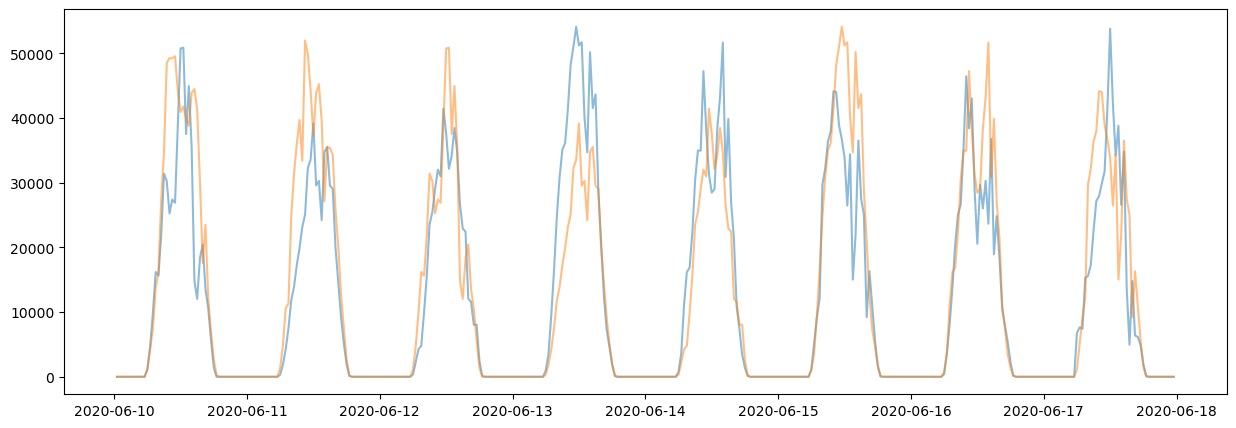

In [48]:
fig, ax = plt.subplots(figsize=(15,5))
# plt.plot(X[X.index > '2020-06-10'].index, y_pred[X.index > '2020-06-10'], alpha=0.5)
plt.plot(X[X.index > '2020-06-10'].index, y[X.index > '2020-06-10'], alpha=0.5)
plt.plot(X[X.index > '2020-06-10'].index, y_baseline[X.index > '2020-06-10'], alpha=0.5)


## Rolling up the data to hourly and 30mins

## Now onto our deep learning model

In [49]:
# reg1 = GradientBoostingRegressor(random_state=1)
# reg2 = RandomForestRegressor(random_state=1)
# reg3 = AdaBoostRegressor(random_state=1)
# xgb = XGBRegressor(random_state=1)
# ereg = VotingRegressor(estimators=[('gb', reg1), ('rf', reg2), ('ada', reg3), ('xgb', xgb)])
# param_grid = {'n_estimators': [25, 50, 75, 100, 200], 'eta': [0.01, 0.05, 0.1, 0.5]}
# param_grid = {'eta': [0.075,0.08,0.1, 0.2, 0.3], 'n_estimators': [10, 15, 20, 25, 30, 35, 40]}
# param_grid = {'eta': [0.078, 0.079, 0.08, 0.085, 0.09], 'n_estimators': [28, 29, 30, 31, 32]}
# param_grid = {'n_estimators':[6], 'eta':[0.30 + 0.001*x for x in range(1, 101)]}
# param_grid={'booster': ['dart', 'gbtree', 'gblinear'], 'n_estimators': [5, 10, 25, 50, 100], 'eta': [0.01, 0.05, 0.1, 0.2, 0.3], 'max_depth' : [1,2,5,7,10] }
# gs = HalvingGridSearchCV(xgb, param_grid=param_grid, cv=cv_index, max_resources=100000, verbose=10)
# gs.fit(X, y)
# gs